#Notebook 2: EDA

We have been given the following data to base our on-time flight performance. This data originated from the U.S. Department of Transportation and consisted of the following dataset. 

***1) Flights Table:*** This table tracks significant airline features from all flights arriving and departing from all major US airports for the 2015-2019 timeframe. We were also given the data from Q1 2015 as well as 1H 2015 to test our airline results

***2) Weather Table:*** We were also given weather data derrived from the National Oceanic and Atmospheric Administration. This data gives the reader an array of weather features (tempearature, wind speed, weather observations, etc.) from all U.S. weather stations. 

***3) Weather Stations Table:*** We were also given weather station data derrived from the National Oceanic and Atmospheric Administration. This data gives the reader the locations (longitude, latitude, etc.) from all U.S. weather stations.

We decided to do brief exploratory data analysis on each of the two datasets seperately to better understand the data and aid us in coalescing our final join. Lastly, we did a range of EDA that was not all shown on this page, we only showed what we thought was the most relevant pieces for our feature engineering work and data joins.

In [0]:
import pandas as pd
import numpy as np
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
#from graphframes import *

from pyspark.sql import functions as f
from pyspark.sql.functions import col

In [0]:
# Inspect the Mount's Final Project folder 
display(dbutils.fs.ls("/mnt/mids-w261/datasets_final_project"))

blob_container = "w261group5container" # The name of your container created in https://portal.azure.com
storage_account = "w261team5storage" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261_group_05" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261_group_05_key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key))

path,name,size
dbfs:/mnt/mids-w261/datasets_final_project/airlines/,airlines/,0
dbfs:/mnt/mids-w261/datasets_final_project/airlines_data/,airlines_data/,0
dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/,parquet_airlines_data/,0
dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data_3m/,parquet_airlines_data_3m/,0
dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data_6m/,parquet_airlines_data_6m/,0
dbfs:/mnt/mids-w261/datasets_final_project/stations_data/,stations_data/,0
dbfs:/mnt/mids-w261/datasets_final_project/weather_data/,weather_data/,0
dbfs:/mnt/mids-w261/datasets_final_project/weather_data_6_hr/,weather_data_6_hr/,0
dbfs:/mnt/mids-w261/datasets_final_project/weather_data_single/,weather_data_single/,0


We created our own tables and inserted them into the Databricks Data for further analysis. Inital exploration of initial rows of the airlines set shows several columns with multiple null values, as well as data divided between departure and arrival categories. This will be explored further in the EDA. 

The weather data likewise, shows null values throughout the featureset. Likewise, the schema shows us that most values are bunched together and cast as strings. They will have to be segmented out to their original parts and cast as doubles or integers for further analysis.

In [0]:
df_airlines = sqlContext.sql("SELECT * FROM tbl_team05_airline_data")
#display(df_airlines)
#df_airlines.printSchema()

df_weather = sqlContext.sql("SELECT * FROM tbl_team05_weather_data")
#display(df_weather)
#df_weather.printSchema()

df_weather_stations = sqlContext.sql("SELECT * FROM tbl_team05_stations_data")
#display(df_weather_stations)
#df_weather_stations.printSchema()

df_full_data = sqlContext.sql("SELECT * FROM team05_joined_full")
#display(df_full_data)
#df_full_data.printSchema()

Summary statistics show XYZ rows for the airline dataset and X% late by 15 minutes or more. This mirrors our flight EDA analysis below which will dive further into the flight status data by year and category.

In [0]:
#total rows
airline_stats = df_airlines.describe().toPandas()
airline_stats

weather_stats = df_weather.describe().toPandas()
weather_stats

weather_station_stats = df_weather_stations.describe().toPandas()
weather_station_stats

full_data_stats = full_data.describe().toPandas()


##2.1) Flight Data EDA

The following plot below shows us that there were X total flights in 20XX,  X total flights in 20XX, X total flights in 20XX, and X total flights in 20XX. Delay percentage has experienced a slight, but not meaningful uptick. The cancellation percentage is relatively flat, settling at X% last year. Likewise, the Diverted percentage remains small and relatively flat at X% in 2019.

year,Flights,Delayed %,Cancelled %,Diverted %
2015,4486023,20.75959039889006,0.06812270021798818,0.2588484276607588
2016,4342249,19.409089621530224,0.045160929278813815,0.2522655886385143
2017,4362149,20.514063137228923,0.044427643347350124,0.21934143010704127
2018,5472382,20.861262974697308,0.06300729737068794,0.2508596804828318
2019,5512172,21.099123902519732,0.0721857010267459,0.2648683676779317


Out[40]:

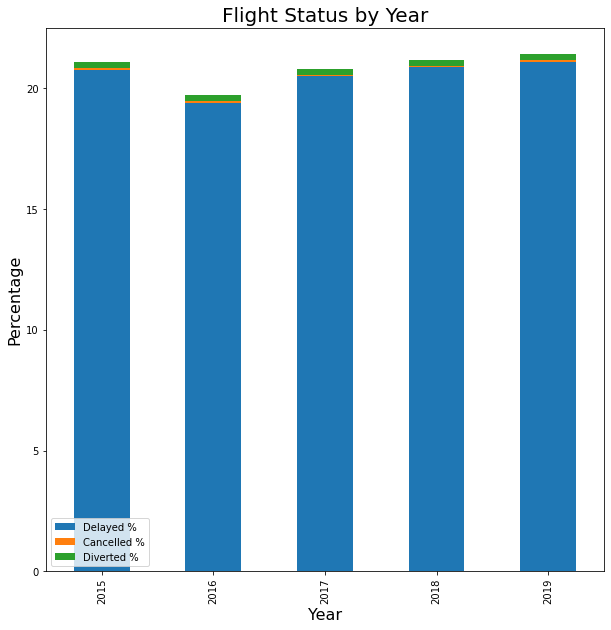

Text(0, 0.5, 'Percentage')

In [0]:
total_flights = df_full_data.select("year", "dep_del15", "cancelled", "diverted").groupBy("year").count().sort(col("year"))
sums = df_full_data.select("year", "dep_del15", "cancelled", "diverted").groupBy("year").sum().sort(col("year"))

total_flights = total_flights.join(sums, "year", how="outer")
total_flights = total_flights.withColumn("Delayed %", (f.col("sum(dep_del15)")/f.col("count"))*100)
total_flights = total_flights.withColumn("Cancelled %", (f.col("sum(cancelled)")/f.col("count"))*100)
total_flights = total_flights.withColumn("Diverted %", (f.col("sum(diverted)")/f.col("count"))*100)
#total_flights = total_flights.withColumn("Ontime %", (100 - f.col("Delayed %") - f.col("Cancelled %") - f.col("Diverted %")))
total_flights = total_flights.drop("sum(year)", "sum(dep_del15)", "sum(cancelled)", "sum(diverted)")
total_flights = total_flights.withColumnRenamed("count","Flights")
display(total_flights)

total_flights = total_flights.toPandas()
total_flights = total_flights.drop(['Flights'], axis = 1)
total_flights = total_flights.set_index('year')

total_flights.plot(kind='bar', stacked=True, figsize=(10,10))
plt.title("Flight Status by Year", fontsize=20)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Percentage", fontsize=16)


We also noticed in the original flight data displays that there were a signficant number of columns with entirely null values. The graph below found that only 17 columns had 95%+ non-null values and only 22 values had less than 80% non-null values. We ultimately decided to drop values with more than 50% null values.

Out[5]:

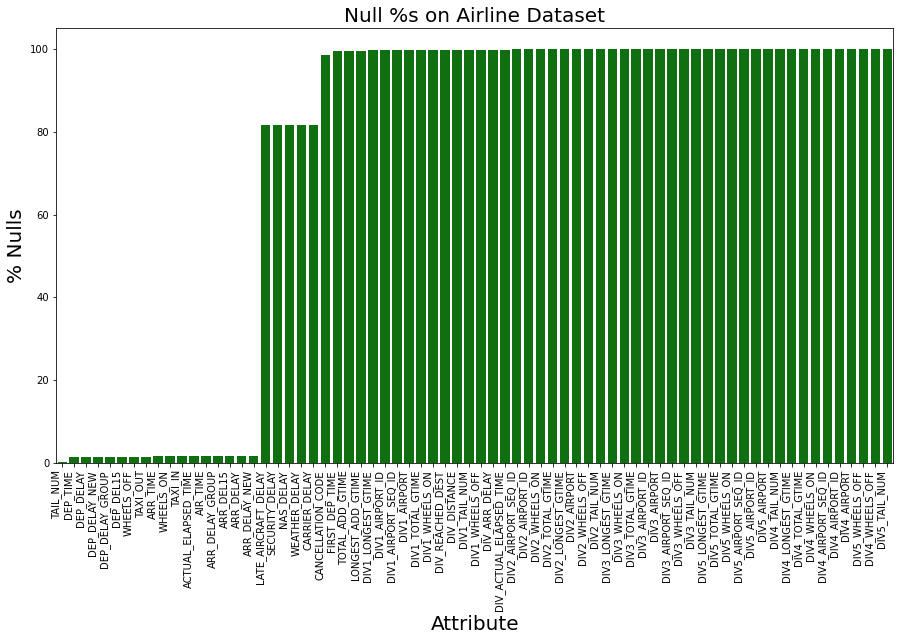

Text(0, 0.5, '% Nulls')

In [0]:
total = df_airlines.count()

null_counts = df_airlines.select([f.count(f.when(f.isnan(col) | f.col(col).isNull(), col)).alias(col) for col in df_airlines.columns]).toPandas().T
null_counts = null_counts.reset_index().rename(columns={'index':'column',0:'null count'}).sort_values('null count')
null_counts['% null'] = 100 * null_counts['null count'] / total
null_counts['% null'] = null_counts['% null'].round(1)

total = df_airlines.count()

fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(x='column', y='% null', data=null_counts[null_counts['% null'] > 0], ax=ax,color="green")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
ax.set_title('Null %s on Airline Dataset', fontsize=20)
ax.set_xlabel("Attribute",fontsize=20)
ax.set_ylabel("% Nulls",fontsize=20)

The data also shows a code that reflects why a flight was delayed. As we can see below, the largest factor for delays were NAS related delays. This means that the National Airspace System (NAS) grounded the flight for reasons including non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control rationale. These delays that occur after Actual Gate Out are usually attributed to the NAS. Late arrival of incoming aircraft were the second largest factor, which will be addressed in the feature engineering section of our analysis. Lastly carrier delays contributed to a large portion of delays (31%), meaning we should consider the airiner as well as a factor for delays.

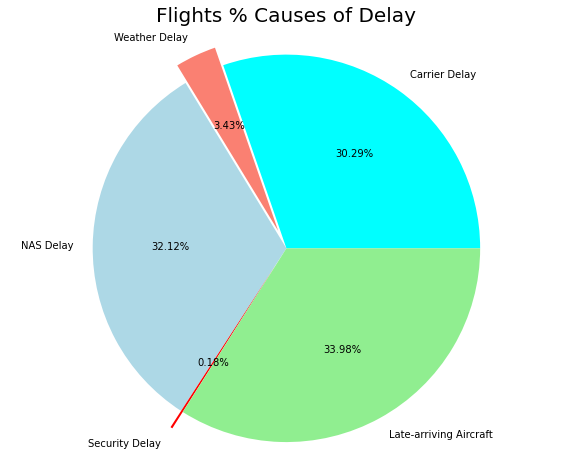

In [0]:
causes_count = df_full_data.groupby().agg(f.count(f.when(f.col('carrier_delay') > 0, True)).alias('num_carrier_delay'),
                                f.count(f.when(f.col('weather_delay') > 0, True)).alias('num_weather_delay'),
                                f.count(f.when(f.col('nas_delay') > 0, True)).alias('num_NAS_delay'),
                                f.count(f.when(f.col('security_delay') > 0,  True)).alias('num_sec_delay'),
                                f.count(f.when(f.col('late_aircraft_delay') > 0, True)).alias('num_late_aircraft')).toPandas().T

total_delays = df_full_data.filter(f.col("dep_del15").isNotNull()).count()

plot_causes = causes_count.rename(columns={0:'count'}).reset_index()
plot_causes['percent'] = np.round(100*(plot_causes['count']/(total_delays)), 2)

fig, axes = plt.subplots(1, 1, figsize=(10,8));
labels = ['Carrier Delay','Weather Delay', 'NAS Delay', 'Security Delay','Late-arriving Aircraft']
sizes = plot_causes.percent
colors = ['cyan', 'salmon', 'lightblue', 'red','lightgreen']
explode = (0, 0.1, 0, 0.1, 0)
axes.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.2f%%')
axes.set_title('Flights % Causes of Delay', fontsize=20)
axes.axis('equal')
plt.show()

Departure and arrival delays are relatively distributed around 0 with the majority of delays being less than 1 hour. The graph below shows us that a sizeable portion of aircraft actually arrive early to their flight compared to the departure time. This means that aircraft are able to make up time in the air in the right circumstances. This was done on the original flights dataset.

Out[10]:

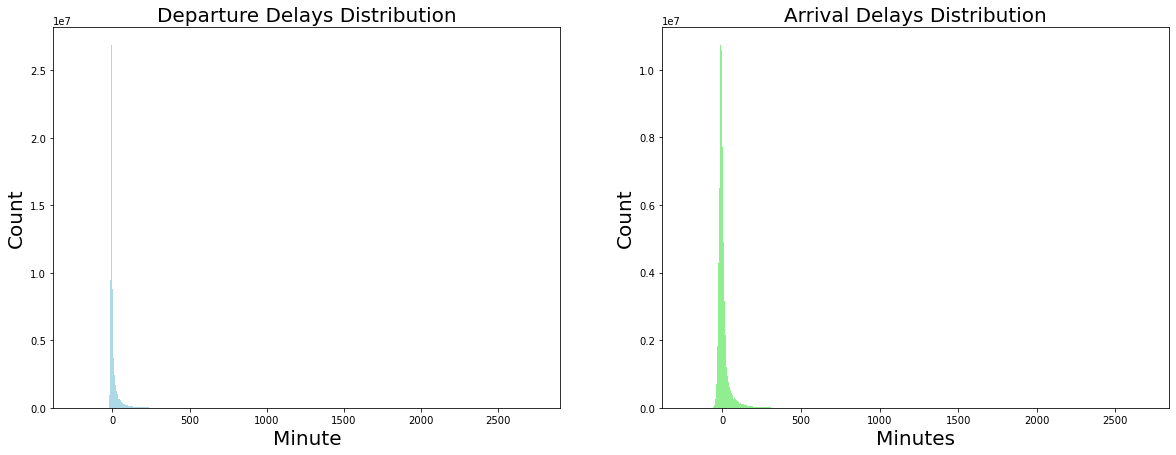

Text(0, 0.5, 'Count')

In [0]:
dep_delay_df = df_airlines.filter(df_airlines.DEP_DEL15.isNotNull())\
             .filter(df_airlines.DEP_DELAY.isNotNull())\
            .select('DEP_DELAY').toPandas()

arr_delay_df = df_airlines.filter(df_airlines.DEP_DEL15.isNotNull())\
             .filter(df_airlines.ARR_DELAY.isNotNull())\
            .select('ARR_DELAY').toPandas()

fig, axes = plt.subplots(1, 2, figsize=(20,7));
axes[0].hist(dep_delay_df.DEP_DELAY, bins=500, color = 'lightblue');
axes[0].set_title('Departure Delays Distribution', fontsize=20)
axes[0].set_xlabel("Minute",fontsize=20)
axes[0].set_ylabel("Count",fontsize=20)
 
axes[1].hist(arr_delay_df.ARR_DELAY, bins=500, color = 'lightgreen');
axes[1].set_title('Arrival Delays Distribution', fontsize=20)
axes[1].set_xlabel("Minutes",fontsize=20)
axes[1].set_ylabel("Count",fontsize=20)

Both Departure and Arrival delays occur most frequently during the summer holiday season in the United States (June - August). Additionally there is a slight uptick in delays in December and January, which could be attributed to the increase in demand due to the Winter Holidays, as well as more severe winter weather.

Out[11]:

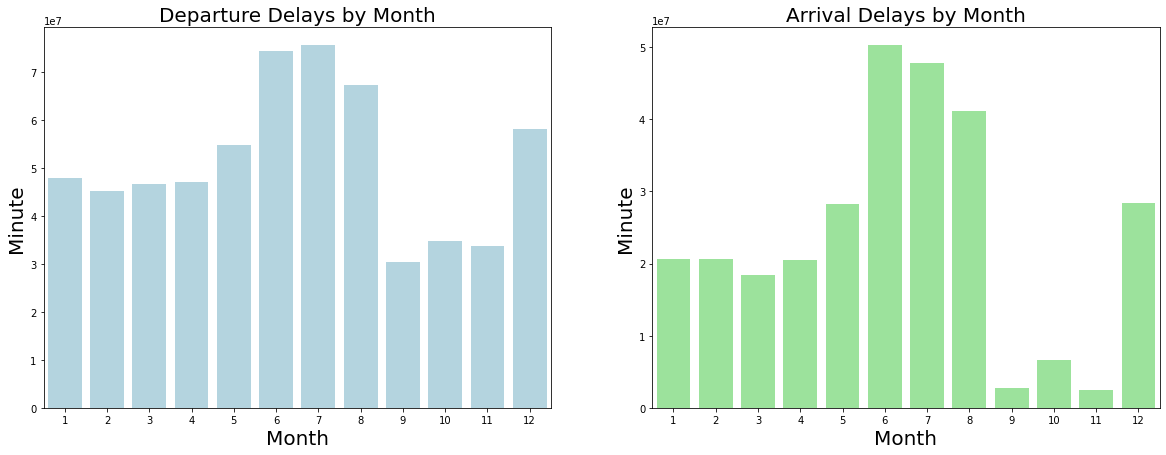

Text(0, 0.5, 'Minute')

In [0]:
byMonth_dep = df_airlines.groupby('MONTH').sum('DEP_DELAY').toPandas()
byMonth_arr = df_airlines.groupby('MONTH').sum('ARR_DELAY').toPandas()

f, axes = plt.subplots(1,2, figsize=(20, 7))
sns.barplot(x='MONTH', y='sum(DEP_DELAY)', data=byMonth_dep, ax=axes[0], color="lightblue")
axes[0].set_title('Departure Delays by Month', fontsize=20)
axes[0].set_xlabel("Month",fontsize=20)
axes[0].set_ylabel("Minute",fontsize=20)

sns.barplot(x='MONTH', y='sum(ARR_DELAY)', data=byMonth_arr, ax=axes[1], color="lightgreen")
axes[1].set_title('Arrival Delays by Month', fontsize=20)
axes[1].set_xlabel("Month",fontsize=20)
axes[1].set_ylabel("Minute",fontsize=20)

The graph below shows that departure and arrival delays occur more frequently later in the day. This may be due to the fact that aircraft are delayed throughout the day or to the fact that there are more flights in this time period. Regardless, the time of day should be heavily factored into our feature set and considered for further feature engineering.

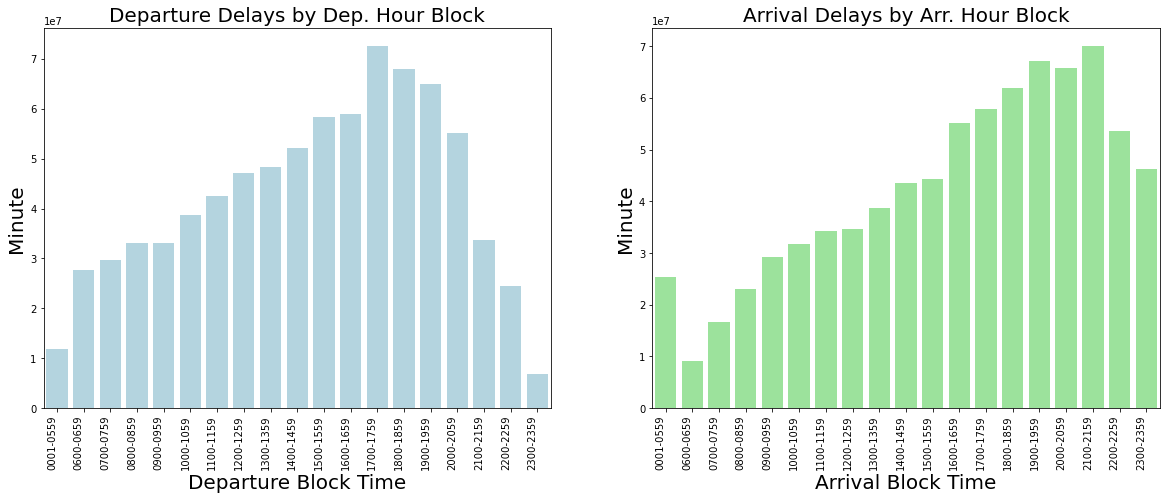

In [0]:
dep_byHour = df_airlines.groupby('DEP_TIME_BLK').sum('DEP_DELAY_NEW').sort('DEP_TIME_BLK').toPandas()
arr_byHour = df_airlines.groupby('ARR_TIME_BLK').sum('ARR_DELAY_NEW').sort('ARR_TIME_BLK').toPandas()

f, axes = plt.subplots(1,2, figsize=(20, 7))
sns.barplot(x='DEP_TIME_BLK', y='sum(DEP_DELAY_NEW)', data=dep_byHour, ax=axes[0], color='lightblue')
axes[0].set_title('Departure Delays by Dep. Hour Block', fontsize=20)
axes[0].set_xlabel('Departure Block Time',fontsize=20)
axes[0].set_ylabel('Minute', fontsize=20)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, horizontalalignment='right')
#axes[0].set_yticklabels(axes[0].get_yticklabels())

sns.barplot(x='ARR_TIME_BLK', y='sum(ARR_DELAY_NEW)', data=arr_byHour, ax=axes[1], color='lightgreen')
axes[1].set_title('Arrival Delays by Arr. Hour Block', fontsize=20)
axes[1].set_xlabel('Arrival Block Time',fontsize=20)
axes[1].set_ylabel('Minute', fontsize=20)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, horizontalalignment='right')
#axes[1].set_yticklabels(axes[1].get_yticklabels())
plt.show()

In [0]:
df_airlines.createOrReplaceTempView("df_airlines")

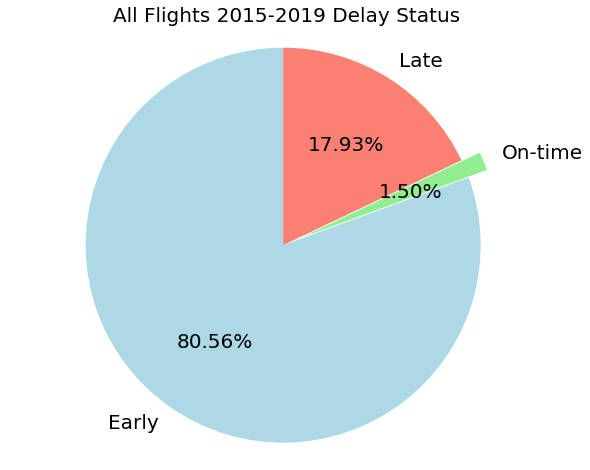

In [0]:
fig, axes = plt.subplots(1, 1, figsize=(10,8));
flights_df = spark.sql("""
select DEP_DEL15, count(*)/ (select count(*) from df_airlines)  as percent
from df_airlines
group by DEP_DEL15""").toPandas()
flights_df.replace({0:'Early', 1:'Late', None:'On-time'}, inplace=True)
labels = flights_df.DEP_DEL15
sizes = flights_df.percent
textprops = {"fontsize":20}
colors = ['lightblue', 'lightgreen', 'salmon']
explode = (0, 0.1, 0)
axes.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.2f%%', startangle = 90, textprops =textprops)
axes.set_title('All Flights 2015-2019 Delay Status', fontsize=20)
axes.axis('equal')
plt.show()

##2.2) Weather Data EDA

Like the flights dataset, we found that the weather dataset contained a signficant amount of features with majority null values. We, likewise, deleted these columnns from or dataset in later analysis.

We also did histogram plots showing the spread on the general weather observations, windspeeds, temperatures, and visibility at time of takeoff. Each of these values had to be segmented out of their original string formats and recast as doubles for the analysis.

Out[24]:

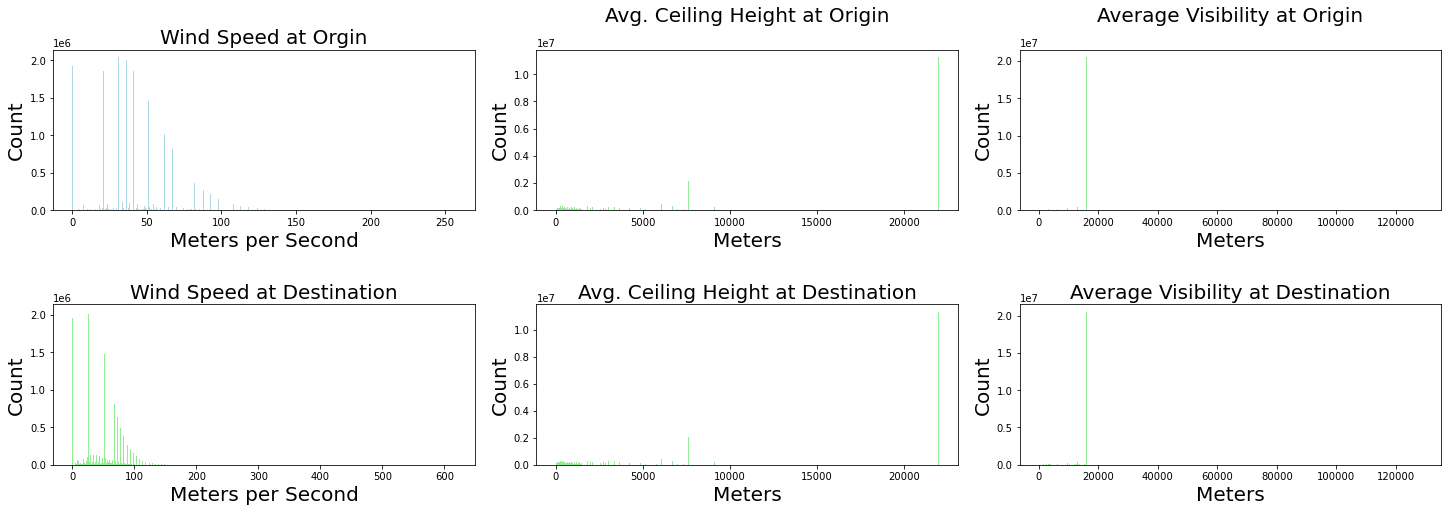

Text(0, 0.5, 'Count')

In [0]:
fig, axes = plt.subplots(2, 3, figsize=(20,7), constrained_layout = True);
df_full_data_pd = df_full_data.select("WND_speed_avg_origin", "WND_speed_avg_dest", "CIG_avg_ceil_ht_origin", 
                                      "CIG_avg_ceil_ht_dest", "avg_VIS_dist_origin", "avg_VIS_dist_dest").toPandas()

axes[0,0].hist(df_full_data_pd.WND_speed_avg_origin, bins=500, color = 'lightblue');
axes[0,0].set_title('Wind Speed at Orgin', fontsize=20)
axes[0,0].set_xlabel("Meters per Second\n",fontsize=20)
axes[0,0].set_ylabel("Count",fontsize=20)
 
axes[1,0].hist(df_full_data_pd.WND_speed_avg_dest, bins=500, color = 'lightgreen');
axes[1,0].set_title('Wind Speed at Destination', fontsize=20)
axes[1,0].set_xlabel("Meters per Second",fontsize=20)
axes[1,0].set_ylabel("Count",fontsize=20)

axes[0,1].hist(df_full_data_pd.CIG_avg_ceil_ht_origin, bins=500, color = 'lightgreen');
axes[0,1].set_title('Avg. Ceiling Height at Origin\n', fontsize=20)
axes[0,1].set_xlabel("Meters",fontsize=20)
axes[0,1].set_ylabel("Count",fontsize=20)

axes[1,1].hist(df_full_data_pd.CIG_avg_ceil_ht_dest, bins=500, color = 'lightgreen');
axes[1,1].set_title('Avg. Ceiling Height at Destination', fontsize=20)
axes[1,1].set_xlabel("Meters",fontsize=20)
axes[1,1].set_ylabel("Count",fontsize=20)

axes[0,2].hist(df_full_data_pd.avg_VIS_dist_origin, bins=500, color = 'lightgreen');
axes[0,2].set_title('Average Visibility at Origin\n', fontsize=20)
axes[0,2].set_xlabel("Meters",fontsize=20)
axes[0,2].set_ylabel("Count",fontsize=20)

axes[1,2].hist(df_full_data_pd.avg_VIS_dist_dest, bins=500, color = 'lightgreen');
axes[1,2].set_title('Average Visibility at Destination', fontsize=20)
axes[1,2].set_xlabel("Meters",fontsize=20)
axes[1,2].set_ylabel("Count",fontsize=20)



Weather data is reported through several different types of reports. As we can see, nearly 50% of reports are from FM-15. The remaining major reporting types are FM-12 at 27% and CRN05 at 12.7%. The FM-X reporting system is pretty common and we may want to throw out other options besides CRN05. if reporting types differ drastically. There are several, smaller and insignificant reporting types used throughout the dataset.

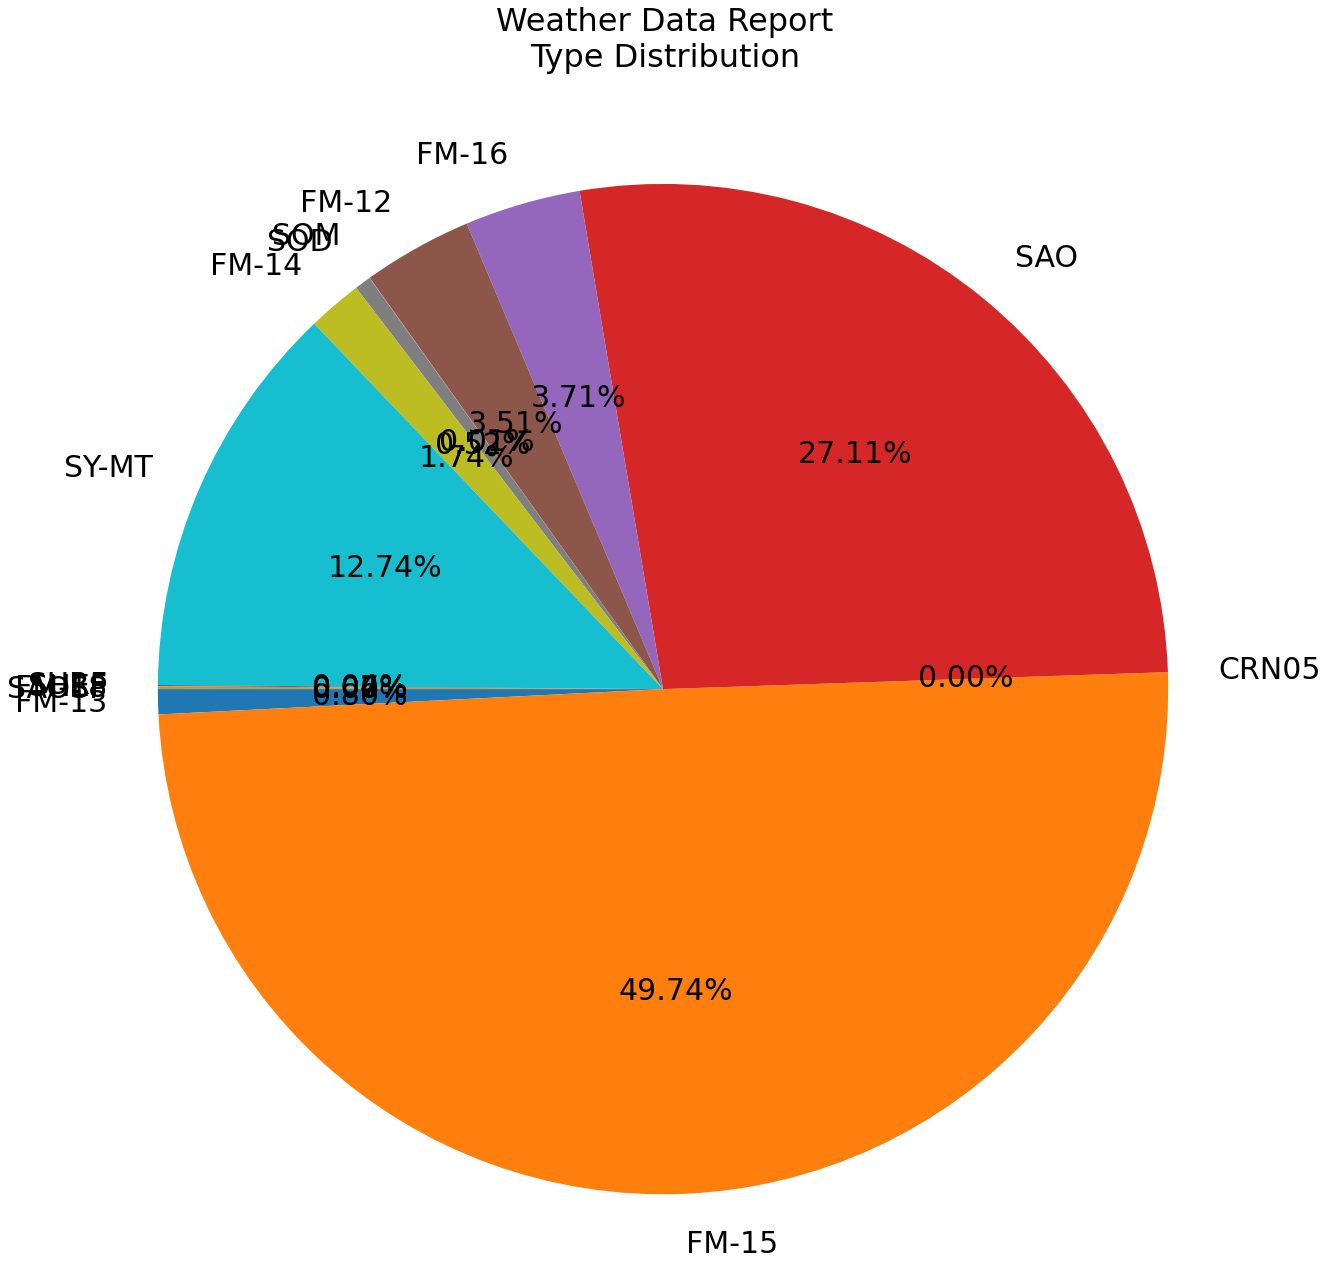

In [0]:
report_types = df_weather.groupBy("REPORT_TYPE").count().toPandas()

total_delays = df_weather.count()

plot_causes = report_types.rename(columns={0:'count'}).reset_index()
plot_causes['percent'] = np.round(100*(report_types['count']/(total_delays)), 2)

#plots the Weather Data Report Type Distribution
fig, axes = plt.subplots(1, 1, figsize=(20,20));
textprops = {"fontsize":30}
labels = ["FM-13","FM-15", "CRN05","SAO","FM-16","FM-12","SOM","SOD","FM-14","SY-MT","SURF","SHEF","FM-18","SAOSP"]
axes.pie(plot_causes.percent, labels=labels, autopct='%1.2f%%', startangle = 180, textprops = textprops)
axes.set_title('Weather Data Report\nType Distribution\n\n', fontsize=32)
axes.axis('equal')
plt.show()

